
<br>
<font>
<!-- <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" alt="SUT logo" width=300 height=300 align=left class="saturate"> -->
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=200 height=200>
<br>
<font color=0F5298 size=7>
Machine Learning <br>
<font color=2565AE size=5>
Electrical Engineering Department <br>
Spring 2024<br>
<font color=3C99D size=5>
Practical Assignment 4 <br>
<font color=696880 size=4>
<!-- <br> -->


____

# Personal Data

In [4]:
student_number = '400101934'
first_name = 'Nikoo'
last_name = 'Moradi'

# Introduction

In this assignment, we will be performing clustering on Spotify songs.

# Data Preprocessing

In the next cell, import the libraries you'll need.

In [5]:
# TODO: Write your code here
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
import random
from sklearn.manifold import TSNE


In the `spotify.csv` file, load the data. Exclude unrelated features and retain only the track name and the features you believe are relevant.

In [6]:
# TODO: Write your code here

# Load the data
file_path = '/content/spotify.csv'
spotify_df = pd.read_csv(file_path)

spotify_features_df = spotify_df[[
    'track_name', 'danceability', 'energy', 'key', 'loudness', 'mode',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence',
    'tempo'
]]

spotify_features_df.head()

,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,I Don't Care (with Justin Bieber) - Loud Luxur...,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036
1,Memories - Dillon Francis Remix,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972
2,All the Time - Don Diablo Remix,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008
3,Call You Mine - Keanu Silva Remix,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956
4,Someone You Loved - Future Humans Remix,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976


In this cell, you should implement a standard scalar function from scratch and applying it to your data. Explain importance behind using a standard scalar and the potential complications that could arise in clustering if it's not employed. (you can't use `sklearn.preprocessing.StandardScaler` but you are free to use `sklearn.preprocessing.LabelEncoder`)

Standardization is important because it ensures that each feature contributes equally to the distance calculations in clustering algorithms, such as K-means. It involves scaling the features of the dataset so that they have a mean of zero and a standard deviation of one.

Potential Complications Without Standardization

**Feature Dominance**: Features with larger ranges can overshadow those with smaller ranges, leading to biased clustering.

**Distorted Distances**: Distance metrics become unreliable if features aren't on the same scale, affecting clustering accuracy.

**Poor Convergence**: Algorithms like K-means may take longer to converge or find suboptimal solutions without standardization.




In [7]:
# TODO: Write your code here
def standard_scaler(df):
    scaled_df = df.copy()

    for column in df.columns:
      # if column != 'track_name':
        mean = df[column].mean()
        std = df[column].std()
        scaled_df[column] = (df[column] - mean) / (std)

    return scaled_df

scaled_spotify_df = standard_scaler(spotify_features_df.drop(columns=['track_name']))
scaled_spotify_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.642039,1.201596,0.173197,1.367103,0.876164,-0.481355,-0.333893,-0.377947,-0.809217,0.031907,0.042926
1,0.490404,0.643307,1.557603,0.585758,0.876164,-0.688631,-0.468663,-0.359172,1.081044,0.782510,-0.777186
2,0.138887,1.284510,-1.211209,1.100073,-1.141305,-0.324417,-0.436792,-0.377843,-0.519554,0.439377,0.116225
3,0.435264,1.278982,0.450078,0.984294,0.876164,-0.050023,-0.667632,-0.377905,0.089580,-1.001780,0.039953
4,-0.033425,0.742804,-1.211209,0.685141,0.876164,-0.702450,-0.432694,-0.377947,-0.692574,0.919763,0.115035


# Dimensionality Reduction

One method for dimensionality reduction is Principal Component Analysis (PCA). Use its implementation from the `sklearn` library to reduce the dimensions of your data. Then, by using an appropriate cut-off for the `_explained_variance_ratio_` in the PCA algorithm, determine the number of principal components to retain.

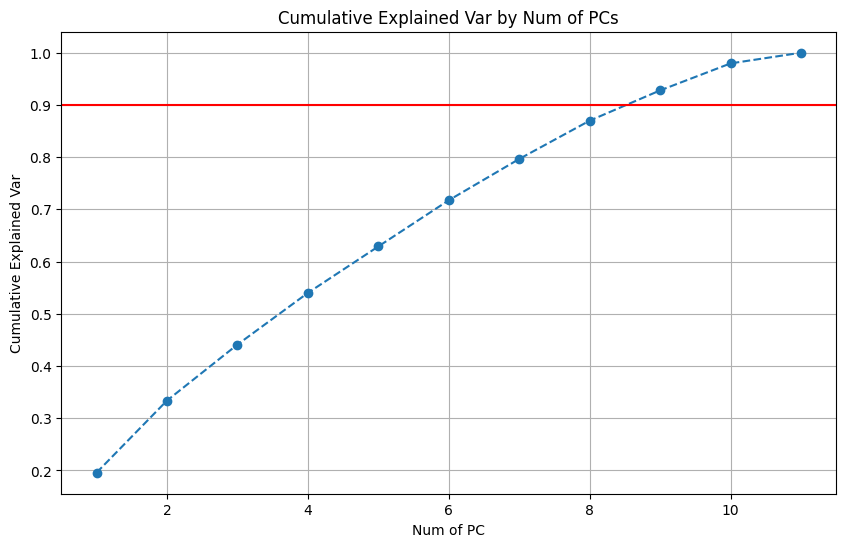

Number of components to retain to explain 90% of the variance: 9


In [8]:
# TODO: Write your code here
scaled_spotify_array = scaled_spotify_df.values

pca = PCA()
pca.fit(scaled_spotify_array)

cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.9, color='r', linestyle='-')
plt.title('Cumulative Explained Var by Num of PCs')
plt.xlabel('Num of PC')
plt.ylabel('Cumulative Explained Var')
plt.grid(True)
plt.show()

# number of components to retain
num_components = np.where(cumulative_explained_variance >= 0.9)[0][0] + 1

print(f'Number of components to retain to explain 90% of the variance: {num_components}')


# Clustering

Implement K-means for clustering from scratch.

In [9]:
def initialize_centroids(X, k):
    np.random.seed(42)
    random_indices = np.random.permutation(X.shape[0])
    centroids = X[random_indices[:k]]
    return centroids

def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def compute_centroids(X, labels, k):
    centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        centroids[i, :] = X[labels == i].mean(axis=0)
    return centroids

def kmeans(X, k, max_iter=300, tol=1e-4):
    centroids = initialize_centroids(X, k)
    for i in range(max_iter):
        labels = assign_clusters(X, centroids)
        new_centroids = compute_centroids(X, labels, k)
        if np.all(np.abs(new_centroids - centroids) <= tol):
            break
        centroids = new_centroids
    return centroids, labels

Using the function you've created to execute the K-means algorithm eight times on your data, with the number of clusters ranging from 2 to 9. For each run, display the genre of each cluster using the first two principal components in a plot.

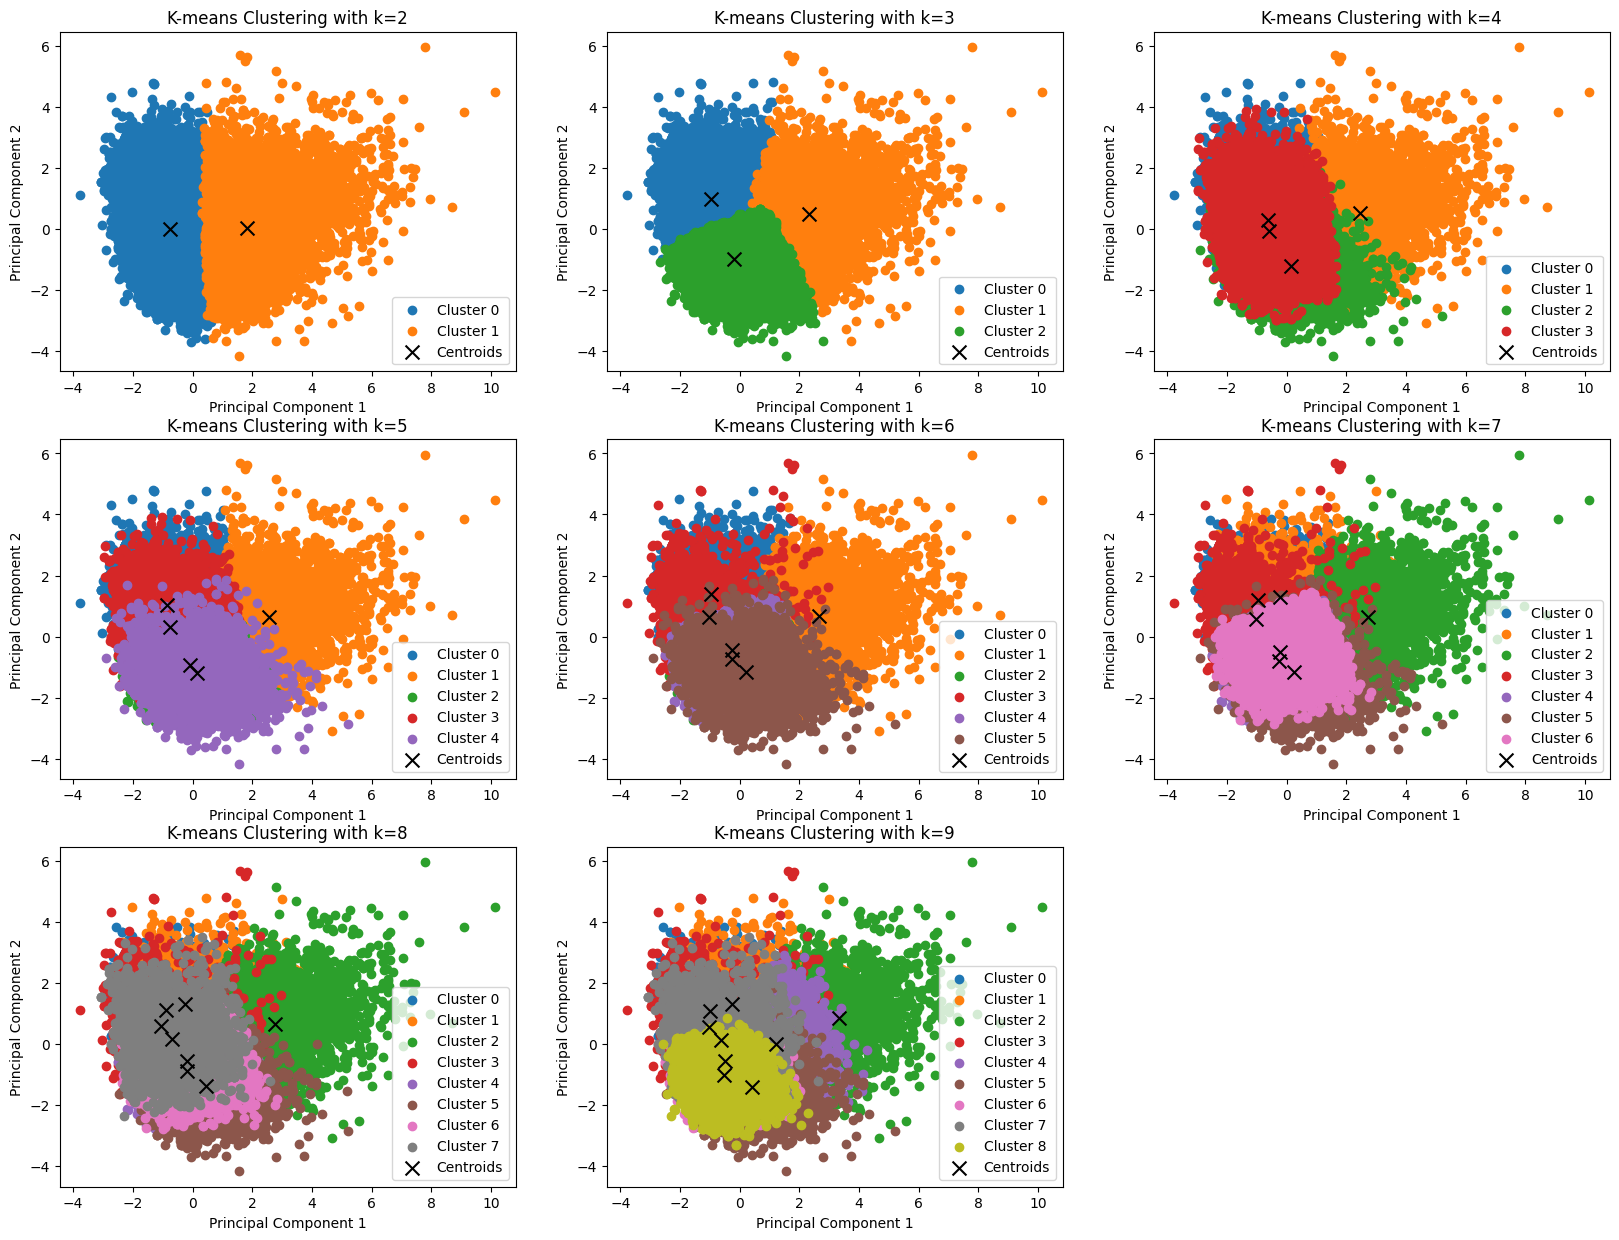

In [10]:
# TODO: Write your code here

def plot_clusters(X, labels, centroids, title):
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = X[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {label}')
    plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroids')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_spotify_array)

plt.figure(figsize=(20, 15))

# K-means
for k in range(2, 10):
    plt.subplot(3, 3, k - 1)
    centroids, labels = kmeans(scaled_spotify_array, k, max_iter=300, tol=1e-4)
    plot_clusters(X_pca, labels, pca.transform(centroids), title=f'K-means Clustering with k={k}')

plt.show()

The Silhouette score and the Within-Cluster Sum of Squares (WSS) score are two metrics used to assess the quality of your clustering. You can find more information about these two methods [here](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb). Plot the Silhouette score and the WSS score for varying numbers of clusters, and use these plots to determine the optimal number of clusters (k).

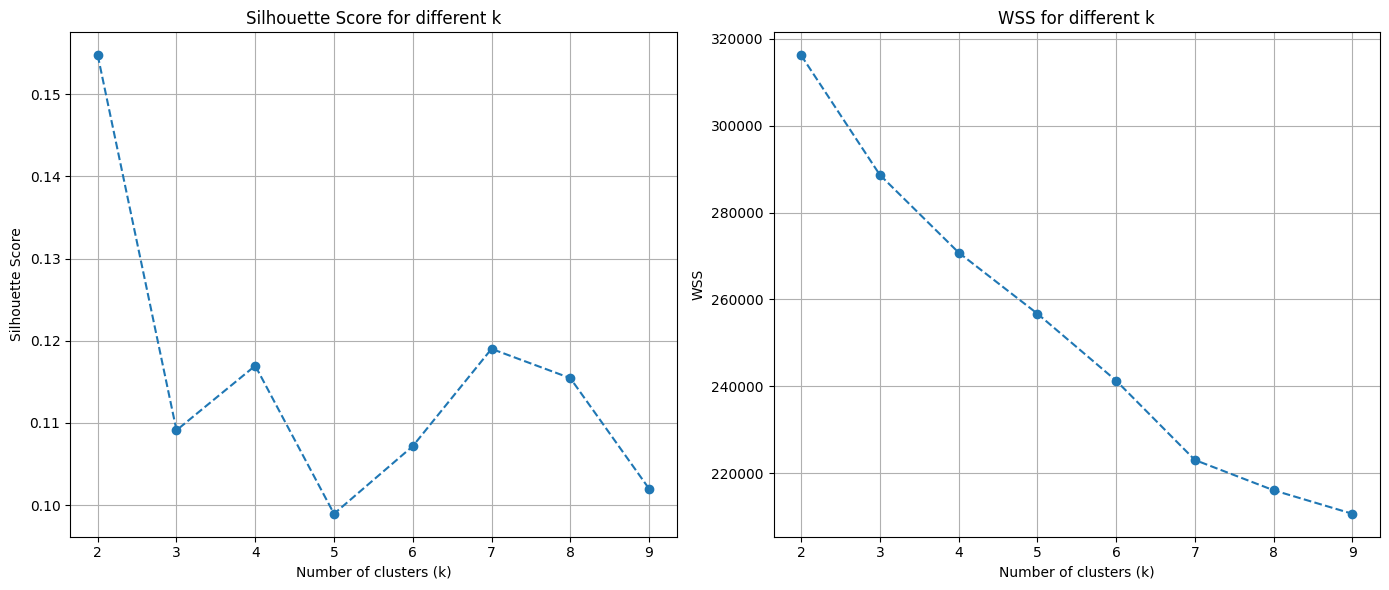

In [12]:
# TODO: Write your code here

# WSS calculation
def calculate_wss(X, labels, centroids):
    wss = 0
    for k in range(centroids.shape[0]):
        cluster_points = X[labels == k]
        wss += np.sum((cluster_points - centroids[k]) ** 2)
    return wss

silhouette_scores = []
wss_scores = []

for k in range(2, 10):
    centroids, labels = kmeans(scaled_spotify_array, k, max_iter=300, tol=1e-4)
    silhouette_avg = silhouette_score(scaled_spotify_array, labels)
    wss = calculate_wss(scaled_spotify_array, labels, centroids)

    silhouette_scores.append(silhouette_avg)
    wss_scores.append(wss)


# Plot Silhouette scores
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for different k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Plot WSS scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 10), wss_scores, marker='o', linestyle='--')
plt.title('WSS for different k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WSS')
plt.grid(True)

plt.tight_layout()
plt.show()


# Checking Output

To see how good was our clustering we will use a sample check and t-SNE method.

first randomly select two song from every cluster and see how close these two songs are.

In [13]:
# TODO: Write your code here

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# randomly select two songs from each cluster and measure their distance
def sample_check(X, labels, track_names, k):
    sample_distances = []
    for cluster in range(k):
        cluster_indices = np.where(labels == cluster)[0]
        if len(cluster_indices) >= 2:
            sample_indices = random.sample(list(cluster_indices), 2)
            song1, song2 = X[sample_indices[0]], X[sample_indices[1]]
            distance = euclidean_distance(song1, song2)
            sample_distances.append((cluster, distance, sample_indices, track_names[sample_indices[0]], track_names[sample_indices[1]]))
        else:
            sample_distances.append((cluster, None, None, None, None))
    return sample_distances

track_names = spotify_features_df['track_name'].values

k = 5
centroids, labels = kmeans(scaled_spotify_array, k, max_iter=300, tol=1e-4)

# Perform the sample check
sample_distances = sample_check(scaled_spotify_array, labels, track_names, k)


for cluster, distance, indices, song1_name, song2_name in sample_distances:
    if distance is not None:
        print(f"Cluster {cluster}: Distance between '{song1_name}' and '{song2_name}' is {distance:.4f}")
    else:
        print(f"Cluster {cluster}: Not enough songs to compare")



Cluster 0: Distance between 'Indigo' and 'Somebody' is 4.3154
Cluster 1: Distance between 'Ace in the Hole' and 'Звезды Воровские' is 3.6485
Cluster 2: Distance between 'Moonlight Jive' and 'You And I - Deadmau5 Remix' is 3.7873
Cluster 3: Distance between 'Sever' and 'Tanz die Revolution (Der Single Mix)' is 4.5540
Cluster 4: Distance between 'Dope Man' and '#1 Stunna' is 3.5436


Using t-SNE reduce dimension of data pointe to 2D and plot it to check how good datapoints are clustered (implementing this part is optional and have extra points)

In [14]:
# TODO: Write your code here

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(scaled_spotify_array)


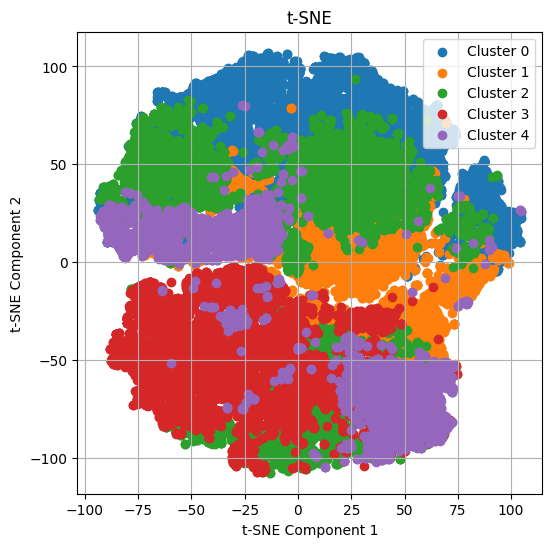

In [15]:
def plot_tsne(X_tsne, labels, title):
    plt.figure(figsize=(6, 6))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = X_tsne[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {label}')
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_tsne(X_tsne, labels, title='t-SNE')